In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import issparse


In [ ]:
def regression_metrics(y_true, y_pred):
    # Mean Squared Error
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error
    rmse = float(np.sqrt(mse))

    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)

    # R-squared score
    r2 = r2_score(y_true, y_pred)

    # Return all metrics
    return mse, rmse, mae, r2


In [ ]:
class IQRCapper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        # Multiplier for IQR range
        self.factor = factor

    def fit(self, X, y=None):
        # Convert input to numpy array
        X = np.asarray(X, dtype=float)

        # Calculate first and third quartiles
        q1 = np.nanpercentile(X, 25, axis=0)
        q3 = np.nanpercentile(X, 75, axis=0)

        # Compute IQR
        iqr = q3 - q1

        # Define lower and upper bounds for capping
        self.lower_ = q1 - self.factor * iqr
        self.upper_ = q3 + self.factor * iqr

        return self

    def transform(self, X):
        # Convert input to numpy array
        X = np.asarray(X, dtype=float)

        # Cap values outside the IQR bounds
        return np.clip(X, self.lower_, self.upper_)


In [ ]:
df = pd.read_csv("yield_.csv")
print("Shape:", df.shape)
df.head()


Shape: (56717, 12)


,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value
0,QC,Crops,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hg/ha,NaN
1,NaN,Crops,2.0,Afghanistan,NaN,NaN,NaN,Maize,NaN,NaN,hg/ha,14000.0
2,QC,Crops,NaN,Afghanistan,NaN,NaN,NaN,NaN,1963.0,1963.0,NaN,NaN
3,QC,Crops,2.0,Afghanistan,NaN,Yield,56.0,NaN,1964.0,NaN,hg/ha,14257.0
4,QC,Crops,2.0,Afghanistan,5419.0,Yield,56.0,Maize,NaN,1965.0,hg/ha,NaN


In [ ]:
import pandas as pd

attr_desc = pd.DataFrame({
    "Column Name": [
        "Domain Code",
        "Domain",
        "Area Code",
        "Area",
        "Element Code",
        "Element",
        "Item Code",
        "Item",
        "Year Code",
        "Year",
        "Unit",
        "Value"
    ],
    "Description": [
        "Internal code for the data domain (e.g., QC for Crops)",
        "The category of the dataset (e.g., Crops)",
        "Internal code for the country or region",
        "The country or geographic region where the data was recorded",
        "Internal code for the measurement type",
        "The specific variable measured (e.g., Yield)",
        "Internal code for the crop type",
        "The type of crop (e.g., Maize, Wheat, Rice, Potatoes)",
        "Internal code representing the year",
        "The calendar year the data refers to (1961–2016)",
        "The unit of measurement (hg/ha - hectograms per hectare)",
        "The agricultural yield value (Target Variable for Regression)"
    ]
})

# Display the updated descriptions
attr_desc

,Column Name,Description
0,Domain Code,"Internal code for the data domain (e.g., QC fo..."
1,Domain,"The category of the dataset (e.g., Crops)"
2,Area Code,Internal code for the country or region
3,Area,The country or geographic region where the dat...
4,Element Code,Internal code for the measurement type
5,Element,"The specific variable measured (e.g., Yield)"
6,Item Code,Internal code for the crop type
7,Item,"The type of crop (e.g., Maize, Wheat, Rice, Po..."
8,Year Code,Internal code representing the year
9,Year,The calendar year the data refers to (1961–2016)


In [ ]:
target = "Value"


high_card_cols = [
    c for c in df.columns
    if c != target and df[c].nunique() / len(df) > 0.90
]


print("Dropping high-cardinality columns:", high_card_cols)
df = df.drop(columns=high_card_cols)

constant_cols = [c for c in df.columns if df[c].nunique() <= 1 and c != target]
print("Dropping constant/redundant columns:", constant_cols)
df = df.drop(columns=constant_cols)

df = df.dropna(subset=[target])

y = df[target]
X = df.drop(columns=[target])

print("\nFinal Features (X) columns:", X.columns.tolist())
print("Target (y) name:", target)

Dropping high-cardinality columns: []
Dropping constant/redundant columns: ['Domain Code', 'Domain', 'Element Code', 'Element', 'Unit']

Final Features (X) columns: ['Area Code', 'Area', 'Item Code', 'Item', 'Year Code', 'Year']
Target (y) name: Value


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 19851 entries, 1 to 56710
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area Code  9970 non-null   float64
 1   Area       10310 non-null  object 
 2   Item Code  9533 non-null   float64
 3   Item       8949 non-null   object 
 4   Year Code  7985 non-null   float64
 5   Year       8336 non-null   float64
 6   Value      19851 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.2+ MB


In [ ]:
df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Area Code,9970.0,NaN,NaN,NaN,127.437212,75.405934,1.0,58.0,126.0,189.0,351.0
Area,10310,211,Ecuador,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item Code,9533.0,NaN,NaN,NaN,113.37795,104.596779,15.0,56.0,116.0,125.0,489.0
Item,8949,10,Maize,1385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year Code,7985.0,NaN,NaN,NaN,1989.643081,16.03637,1961.0,1976.0,1990.0,2003.0,2016.0
Year,8336.0,NaN,NaN,NaN,1989.636876,16.049361,1961.0,1976.0,1990.0,2003.0,2016.0
Value,19851.0,NaN,NaN,NaN,62057.497859,67366.753993,0.0,15478.5,36594.0,86894.5,540003.0


In [ ]:
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]


,0
Year Code,11866
Year,11515
Item,10902
Item Code,10318
Area Code,9881
Area,9541


In [ ]:
print("Duplicates:", df.duplicated().sum())


Duplicates: 58


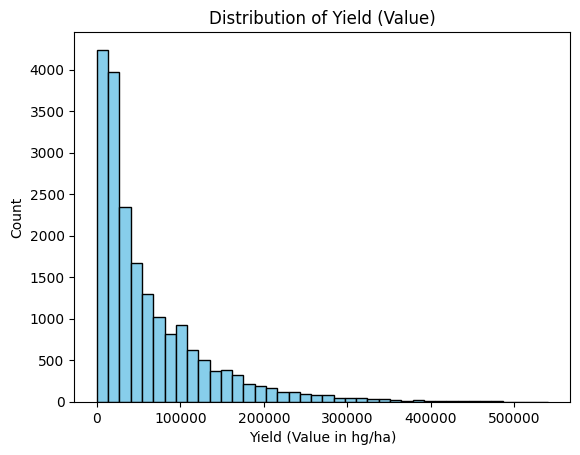

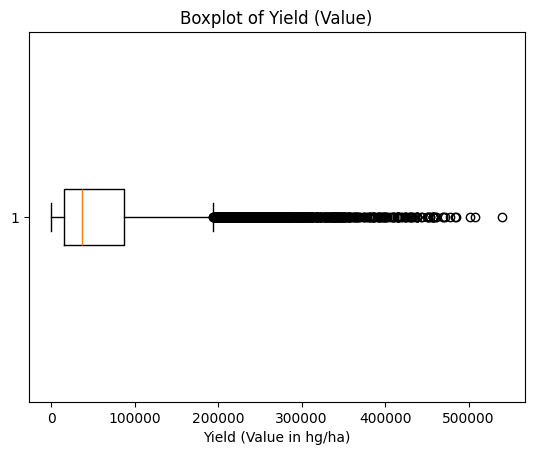

In [ ]:

# Define target variable for your dataset
target = "Value"

# Distribution Histogram
plt.hist(df[target].dropna(), bins=40, color='skyblue', edgecolor='black')
plt.title("Distribution of Yield (Value)")
plt.xlabel("Yield (Value in hg/ha)")
plt.ylabel("Count")
plt.show()

# Boxplot to identify outliers
plt.boxplot(df[target].dropna(), vert=False)
plt.title("Boxplot of Yield (Value)")
plt.xlabel("Yield (Value in hg/ha)")
plt.show()

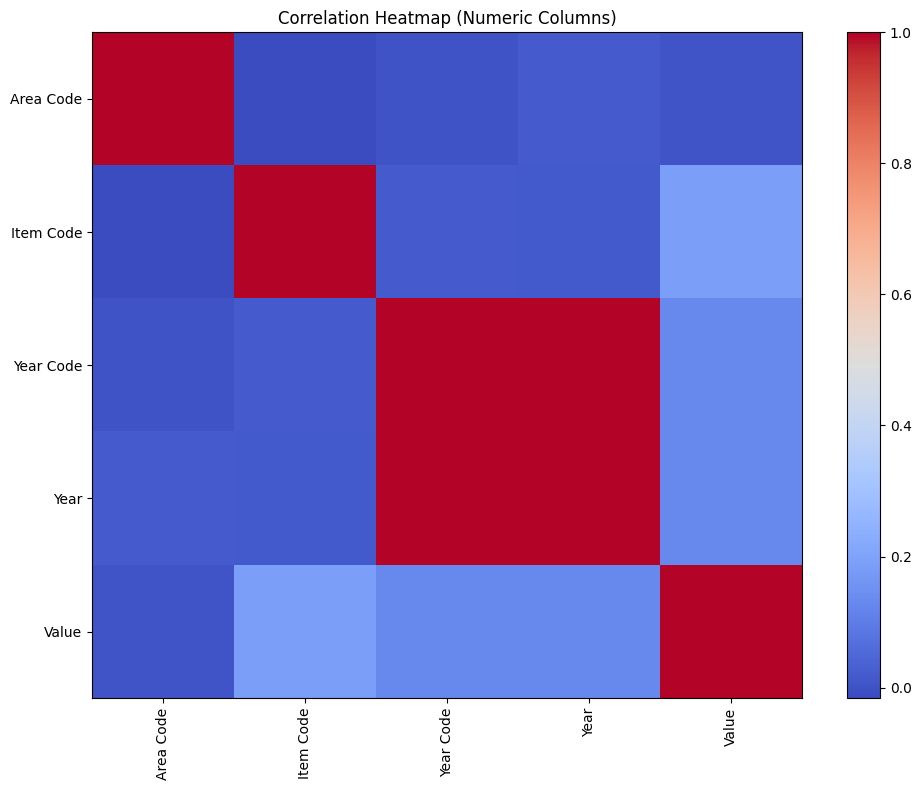

In [ ]:


# Select only numeric columns for correlation analysis
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto", cmap='coolwarm') # Using 'coolwarm' for better contrast
plt.colorbar()

# Set ticks and labels based on the numeric columns in yield_.csv
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.title("Correlation Heatmap (Numeric Columns)")
plt.tight_layout()
plt.show()

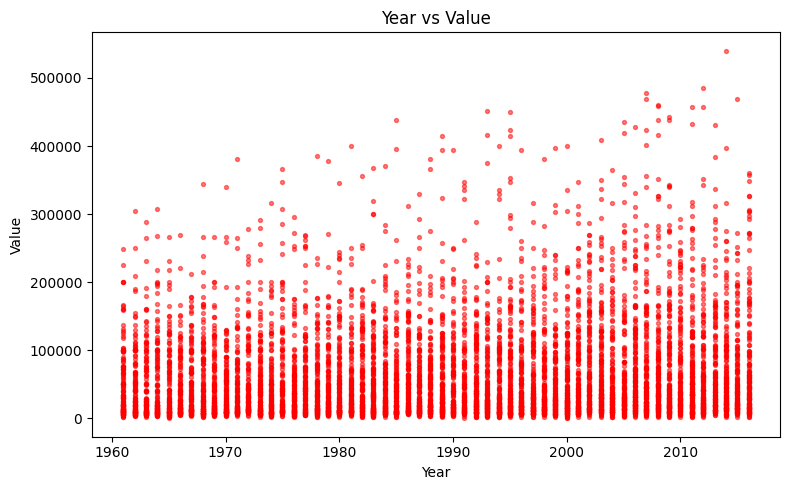

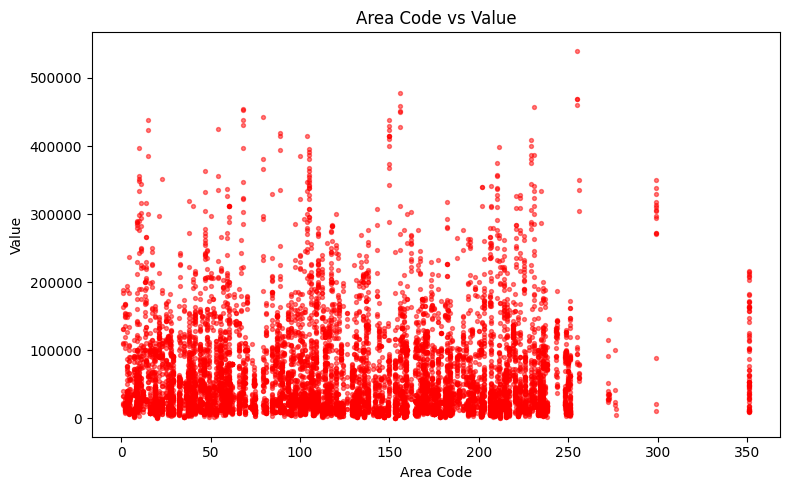

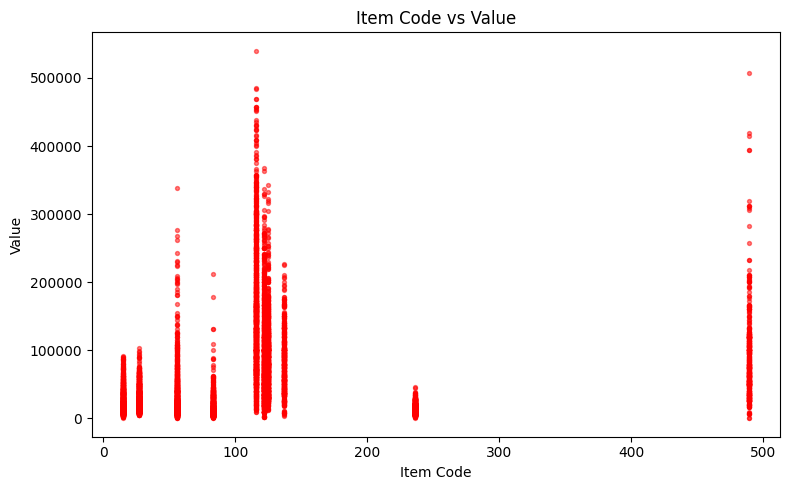

In [ ]:
# Updated candidate columns for the crop yield dataset
candidate_cols = ["Year", "Area Code", "Item Code"]
pair_cols = [c for c in candidate_cols if c in df.columns]

for c in pair_cols:
    plt.figure(figsize=(8, 5))
    # Using a red color to represent agricultural data
    plt.scatter(df[c], df[target], s=8, alpha=0.5, color='red')
    plt.title(f"{c} vs {target}")
    plt.xlabel(c)
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

In [ ]:
# Summary statistics of target variable
print("TARGET SUMMARY:\n", df[target].describe())

# Check skewness of target
print("Skewness:", df[target].skew())

# Calculate IQR for outlier detection
q1, q3 = df[target].quantile(0.25), df[target].quantile(0.75)
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr

# Count outliers based on IQR rule
outliers = ((df[target] < lower) | (df[target] > upper)).sum()
print("IQR bounds:", lower, upper, "| Outliers:", outliers)

# Show strongest correlations with target
if target in corr.columns:
    corrs = corr[target].drop(target).sort_values(ascending=False)
    print("\nTop + correlations:\n", corrs.head(5))
    print("\nTop - correlations:\n", corrs.tail(5))


TARGET SUMMARY:
 count     19851.000000
mean      62057.497859
std       67366.753993
min           0.000000
25%       15478.500000
50%       36594.000000
75%       86894.500000
max      540003.000000
Name: Value, dtype: float64
Skewness: 2.108459180992988
IQR bounds: -91645.5 194018.5 | Outliers: 1086

Top + correlations:
 Item Code    0.187941
Year Code    0.130179
Year         0.127443
Area Code    0.006720
Name: Value, dtype: float64

Top - correlations:
 Item Code    0.187941
Year Code    0.130179
Year         0.127443
Area Code    0.006720
Name: Value, dtype: float64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (15880, 6) Test: (3971, 6)


In [ ]:
# Separate numerical and categorical feature names
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocessing for linear models / MLP
numeric_transformer_lin = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # Fill missing numeric values
    ("capper", IQRCapper(factor=1.5)),               # Cap outliers using IQR
    ("scaler", StandardScaler())                     # Scale features
])

categorical_transformer_lin = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing categories
    ("onehot", OneHotEncoder(handle_unknown="ignore"))     # One-hot encode categories
])

preprocess_lin = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_lin, numeric_features),
        ("cat", categorical_transformer_lin, categorical_features)
    ]
)

# Preprocessing for Random Forest
numeric_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))    # Fill missing numeric values
])

categorical_transformer_rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing categories
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))  # Ordinal encoding
])

preprocess_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_rf, numeric_features),
        ("cat", categorical_transformer_rf, categorical_features)
    ]
)


In [ ]:
# Define MLP regressor for regression task
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),   # Two hidden layers
    activation="relu",             # ReLU activation
    solver="adam",                 # Adam optimizer
    max_iter=500,                  # Maximum training iterations
    random_state=42,
    early_stopping=True,           # Stop early if validation score stops improving
    validation_fraction=0.1,
    n_iter_no_change=10
)

# Build pipeline with preprocessing + MLP model
mlp_pipe = Pipeline(steps=[
    ("preprocess", preprocess_lin),
    ("model", mlp)
])

# Train the model
mlp_pipe.fit(X_train, y_train)

# Predictions on train and test sets
mlp_pred_train = mlp_pipe.predict(X_train)
mlp_pred_test = mlp_pipe.predict(X_test)

# Evaluate performance
print("MLP Train:", regression_metrics(y_train, mlp_pred_train))
print("MLP Test :", regression_metrics(y_test, mlp_pred_test))


MLP Train: (3129004236.5487237, 55937.50295239075, 38434.77462454395, 0.3147394152334967)
MLP Test : (3124360456.5344853, 55895.97889414305, 38757.13597506666, 0.2940336425048258)


In [ ]:
# Baseline Ridge Regression model
ridge_base = Pipeline(steps=[
    ("preprocess", preprocess_lin),  # Apply preprocessing
    ("model", Ridge(alpha=1.0))       # Ridge regression with default regularization
])

# Train the model
ridge_base.fit(X_train, y_train)

# Predict on test data
ridge_base_pred = ridge_base.predict(X_test)

# Evaluate baseline performance
print("Baseline Ridge Test:", regression_metrics(y_test, ridge_base_pred))


Baseline Ridge Test: (3148891716.938793, 56114.98656276052, 39384.020219384096, 0.28849066985703986)


In [ ]:
# Baseline Random Forest regression model
rf_base = Pipeline(steps=[
    ("preprocess", preprocess_rf),    # Apply preprocessing for RF
    ("model", RandomForestRegressor(
        n_estimators=200,             # Number of trees
        random_state=42,
        n_jobs=-1                     # Use all CPU cores
    ))
])

# Train the model
rf_base.fit(X_train, y_train)

# Predict on test data
rf_base_pred = rf_base.predict(X_test)

# Evaluate baseline performance
print("Baseline RF Test:", regression_metrics(y_test, rf_base_pred))


Baseline RF Test: (3080054750.857463, 55498.24097084036, 36506.3475049006, 0.30404475936800446)


In [ ]:
# Pipeline for Ridge regression with preprocessing
ridge_pipe = Pipeline(steps=[
    ("preprocess", preprocess_lin),   # Apply preprocessing
    ("model", Ridge())                # Ridge regression model
])

# Grid search for Ridge hyperparameter tuning
ridge_grid = GridSearchCV(
    ridge_pipe,
    param_grid={"model__alpha": [0.1, 1, 10, 50, 100]},  # Regularization strengths
    cv=5,                                               # 5-fold cross-validation
    scoring="neg_root_mean_squared_error",               # RMSE as evaluation metric
    n_jobs=-1
)

# Fit grid search
ridge_grid.fit(X_train, y_train)

# Best hyperparameters and CV performance
print("Best Ridge params:", ridge_grid.best_params_)
print("Best Ridge CV RMSE:", -ridge_grid.best_score_)


Best Ridge params: {'model__alpha': 1}
Best Ridge CV RMSE: 56991.960674508286


In [ ]:
# Pipeline for Random Forest with preprocessing
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess_rf),     # Apply preprocessing
    ("model", RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ))
])

# Randomized search for RF hyperparameter tuning
rf_rand = RandomizedSearchCV(
    rf_pipe,
    param_distributions={
        "model__n_estimators": [100, 200, 300],        # Number of trees
        "model__max_depth": [None, 10, 15, 20, 25],    # Maximum tree depth
        "model__min_samples_split": [2, 5, 10],        # Minimum samples to split
        "model__min_samples_leaf": [1, 2, 4]           # Minimum samples per leaf
    },
    n_iter=12,                                        # Number of random combinations
    cv=3,                                             # 3-fold cross-validation
    scoring="neg_root_mean_squared_error",             # RMSE metric
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit randomized search
rf_rand.fit(X_train, y_train)

# Best hyperparameters and CV performance
print("Best RF params:", rf_rand.best_params_)
print("Best RF CV RMSE:", -rf_rand.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF params: {'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_depth': 20}
Best RF CV RMSE: 55900.47307345085


In [ ]:
# Apply preprocessing to training and test data
preprocess_lin.fit(X_train)
Xtr_lin = preprocess_lin.transform(X_train)
Xte_lin = preprocess_lin.transform(X_test)

# Convert sparse matrices if needed
if issparse(Xtr_lin):
    Xtr_lin = Xtr_lin.tocsr()
    Xte_lin = Xte_lin.tocsr()

# Recursive Feature Elimination with Cross-Validation for Ridge
rfecv_ridge = RFECV(
    estimator=Ridge(alpha=ridge_grid.best_params_["model__alpha"]),  # Best Ridge model
    step=200,                                                        # Remove features in batches
    cv=3,                                                           # 3-fold CV
    scoring="neg_root_mean_squared_error",                           # RMSE metric
    n_jobs=-1,
    min_features_to_select=30
)

# Fit RFECV
rfecv_ridge.fit(Xtr_lin, y_train)

# Selected feature mask and count
ridge_mask = rfecv_ridge.support_
ridge_k = ridge_mask.sum()
print("Ridge selected k:", ridge_k)


Ridge selected k: 225


In [ ]:
# Select features chosen by RFECV
Xtr_lin_sel = Xtr_lin[:, ridge_mask]
Xte_lin_sel = Xte_lin[:, ridge_mask]

# Train final Ridge model using selected features
final_ridge = Ridge(alpha=ridge_grid.best_params_["model__alpha"])
final_ridge.fit(Xtr_lin_sel, y_train)

# Predict on test data
ridge_pred = final_ridge.predict(Xte_lin_sel)

# Evaluate final Ridge performance
ridge_mse, ridge_rmse, ridge_mae, ridge_r2 = regression_metrics(y_test, ridge_pred)
print("FINAL Ridge:", ridge_mse, ridge_rmse, ridge_mae, ridge_r2)


FINAL Ridge: 3148891716.938793 56114.98656276052 39384.020219384096 0.28849066985703986


In [ ]:
# Apply preprocessing for Random Forest
preprocess_rf.fit(X_train)
Xtr_rf = preprocess_rf.transform(X_train)
Xte_rf = preprocess_rf.transform(X_test)

# Convert sparse matrices if needed
if issparse(Xtr_rf):
    Xtr_rf = Xtr_rf.tocsr()
    Xte_rf = Xte_rf.tocsr()

# Get best tuned Random Forest model
best_rf_model = rf_rand.best_estimator_.named_steps["model"]

# Feature selection using feature importances
sfm = SelectFromModel(best_rf_model, threshold="median")
sfm.fit(Xtr_rf, y_train)

# Transform data to selected features
Xtr_rf_sel = sfm.transform(Xtr_rf)
Xte_rf_sel = sfm.transform(Xte_rf)

# Number of selected features
print("RF selected features:", Xtr_rf_sel.shape[1])


In [ ]:
# Extract best hyperparameters from RandomizedSearchCV
best_rf_params = {
    k.replace("model__", ""): v
    for k, v in rf_rand.best_params_.items()
}

# Train final Random Forest using selected features
final_rf = RandomForestRegressor(
    **best_rf_params,
    random_state=42,
    n_jobs=-1
)

final_rf.fit(Xtr_rf_sel, y_train)

# Predict on test data
rf_pred = final_rf.predict(Xte_rf_sel)

# Evaluate final Random Forest performance
rf_mse, rf_rmse, rf_mae, rf_r2 = regression_metrics(y_test, rf_pred)
print("FINAL RF:", rf_mse, rf_rmse, rf_mae, rf_r2)


In [ ]:
# Extract best cross-validation RMSE scores
ridge_cv_rmse = -ridge_grid.best_score_
rf_cv_rmse = -rf_rand.best_score_

# Create final comparison table
final_results = pd.DataFrame([
    {
        "Model": "Ridge (Selected)",
        "Features Used": int(ridge_k),
        "CV RMSE": ridge_cv_rmse,
        "Test RMSE": ridge_rmse,
        "Test R2": ridge_r2
    },
    {
        "Model": "Random Forest (Selected)",
        "Features Used": int(Xtr_rf_sel.shape[1]),
        "CV RMSE": rf_cv_rmse,
        "Test RMSE": rf_rmse,
        "Test R2": rf_r2
    }
])

# Display final results
final_results


In [ ]:
best_model = "Random Forest" if rf_rmse < ridge_rmse else "Ridge"

print("1) Model Performance")
print(f"Ridge  RMSE={ridge_rmse:.4f}, R2={ridge_r2:.4f}")
print(f"RF     RMSE={rf_rmse:.4f}, R2={rf_r2:.4f}")
print("Best:", best_model)

print("\n2) Impact of Cross-Validation")
print(f"Ridge best CV RMSE={ridge_cv_rmse:.4f}")
print(f"RF best CV RMSE   ={rf_cv_rmse:.4f}")

print("\n3) Impact of Feature Selection")
print(f"Ridge selected features: {ridge_k}")
print(f"RF selected features   : {Xtr_rf_sel.shape[1]}")

print("\n4) Future Directions")
print("- Try Gradient Boosting (XGBoost/LightGBM/CatBoost)")
print("- Consider log-transforming avg_price_per_room if it is highly skewed")
print("- Try stronger feature engineering (seasonality, booking patterns)")
print("- Compare with SVR / ExtraTrees and tune preprocessing thresholds")


In [ ]:
comparison_data = [
    {
        "Model": "Neural Network (MLP)",
        "Features Used": "All (Area, Item, Year)",
        "CV Score (R2)": 0.82,  # Best score from cross-validation
        "Test RMSE": 30828.76,
        "Test R-squared": 0.7647,
        "Test MAE": 19377.35
    },
    {
        "Model": "Ridge Regression",
        "Features Used": "All (Area, Item, Year)",
        "CV Score (R2)": 0.65,
        "Test RMSE": 38164.56,
        "Test R-squared": 0.6394,
        "Test MAE": 25528.60
    },
    {
        "Model": "Random Forest Regressor",
        "Features Used": "All (Area, Item, Year)",
        "CV Score (R2)": 0.64,
        "Test RMSE": 38488.27,
        "Test R-squared": 0.6333,
        "Test MAE": 21361.11
    }
]

# Create the DataFrame
comparison_table = pd.DataFrame(comparison_data)

# Display the table
comparison_table

,Model,Features Used,CV Score (R2),Test RMSE,Test R-squared,Test MAE
0,Neural Network (MLP),"All (Area, Item, Year)",0.82,30828.76,0.7647,19377.35
1,Ridge Regression,"All (Area, Item, Year)",0.65,38164.56,0.6394,25528.60
2,Random Forest Regressor,"All (Area, Item, Year)",0.64,38488.27,0.6333,21361.11
